In [89]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp
import utils
import time
import random
import pickle

seed: 278
x0	shape:(1608,)


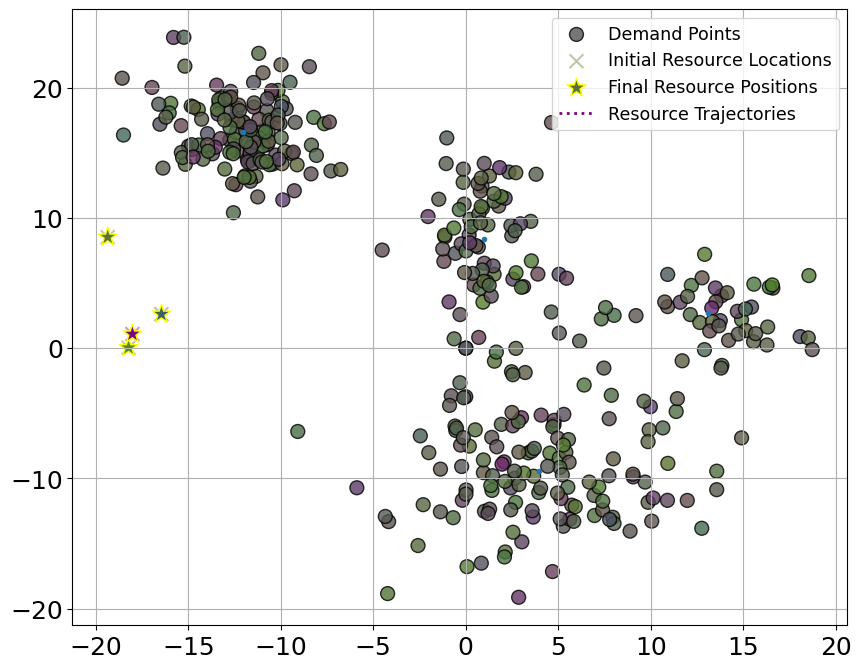

rho shape: (400, 1)
cluster split: [0.34909323 0.19156309 0.33372809 0.12561558]
upper allocation cost limit: [0.37566646 0.16594861 0.35034683 0.1880381 ]
lower allocation cost limit: [0.08103281 0.06742873 0.09044801 0.09059003]
res means: [[-12.05548203  16.63227142]
 [  0.97248462   8.35893085]
 [  3.97295221  -9.43936502]
 [ 13.07212666   2.66832899]]
centroid:[-1.04948549  4.56286344]


In [97]:
reload(utils)
reload(class_flp)

# load/generate a testcase
N = 400
M = 4
d = 2
scale = 20
# seed = random.randint(0,1000)
seed = 278

# 123, 233, 94, 830 for N = 1000, M = 10, 
# 864 for N = 400, M = 3
# 349, 700, 477, 278 for N = 400, M = 4
print(f'seed: {seed}')
# N, M, d, demandLoc, Y0, demand_means, split_pct, rho = testcases.testcase_catalog('small_tc_300_3')
demandLoc, Y0, demand_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=20, seed=seed, sq_size=scale, normalizer=False)
# allocation cost
alloc_cost = np.random.uniform(1,1,(N,M))
mean_alloc_cost = np.mean(alloc_cost)
C = np.random.uniform(0.3,1,len(split_pct))
# C = np.ones(shape=split_pct.shape)
C = (C/np.sum(C) + 0.02) * mean_alloc_cost
B = np.random.uniform(C.min()*0.3, C.min()*0.6, len(split_pct))

# initialize FLP class
flp = class_flp.FLP(N, M, d, demandLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

# initialize state
Y0 = np.column_stack((np.random.uniform(-20.0, -15.0, flp.M), 
                          np.random.uniform(0.0, 10.0, flp.M)))
# Y0 = np.random.uniform(0*scale,1*scale,(flp.M, flp.d))
np.random.seed(seed)
P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
P0 = P0/P0.sum(axis=1,keepdims=True)
x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

class_flp.plot_flp(flp, demand_means, np.expand_dims(Y0,axis=0), np.expand_dims(P0,axis=0),figSize=(10,8))
print(f'rho shape: {rho.shape}')
print(f'cluster split: {split_pct}')
print(f'upper allocation cost limit: {C}')
print(f'lower allocation cost limit: {B}')
print(f'res means: {demand_means}')
centroid = np.sum(rho*demandLoc, axis=0)
print(f'centroid:{centroid}')


In [98]:
# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3

# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

### Regular DA (Unconstrained)

This is the classical Deterministic Annealing (DA) approach, originally proposed by Kenneth Rose in *"Deterministic Annealing for Clustering, Compression, Classification, Regression, and Related Optimization Problems," Proceedings of the IEEE*, 1998 ([link](https://doi.org/10.1109/5.726788)).


tolerance achieved: 	 norm_diff_D=5.836e-06
b:1.000e-03	F:215.2350
tolerance achieved: 	 norm_diff_D=8.532e-06
b:2.000e-03	F:215.2344
tolerance achieved: 	 norm_diff_D=8.599e-06
b:4.000e-03	F:197.4247
tolerance achieved: 	 norm_diff_D=9.824e-06
b:8.000e-03	F:142.4950
tolerance achieved: 	 norm_diff_D=9.927e-06
b:1.600e-02	F:99.1968
tolerance achieved: 	 norm_diff_D=8.957e-06
b:3.200e-02	F:68.4926
tolerance achieved: 	 norm_diff_D=9.926e-06
b:6.400e-02	F:51.3593
tolerance achieved: 	 norm_diff_D=7.881e-06
b:1.280e-01	F:42.2308
tolerance achieved: 	 norm_diff_D=7.976e-06
b:2.560e-01	F:24.9232
tolerance achieved: 	 norm_diff_D=4.713e-06
b:5.120e-01	F:22.2276
tolerance achieved: 	 norm_diff_D=2.779e-06
b:1.024e+00	F:20.8737
tolerance achieved: 	 norm_diff_D=1.514e-06
b:2.048e+00	F:20.1988
tolerance achieved: 	 norm_diff_D=1.995e-06
b:4.096e+00	F:19.8583
tolerance achieved: 	 norm_diff_D=3.481e-10
b:8.192e+00	F:19.6894
tolerance achieved: 	 norm_diff_D=0.000e+00
b:1.638e+01	F:19.6052
tolera

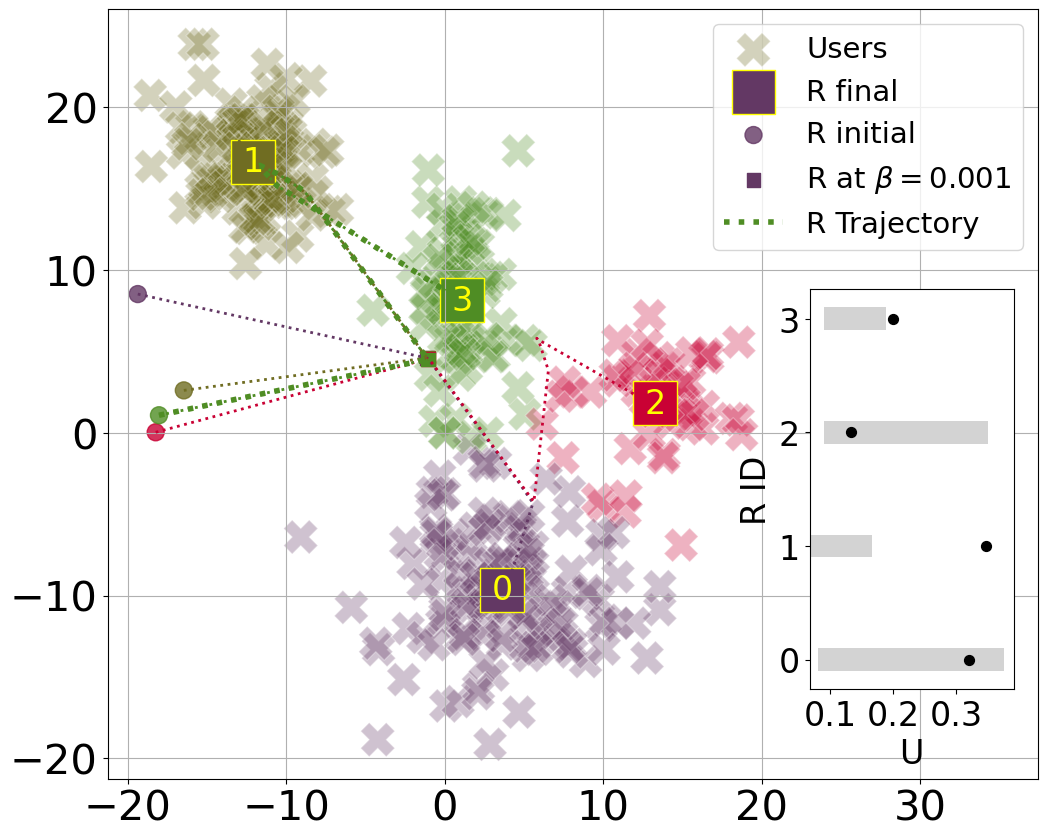

In [99]:
t0_da = time.time()
F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_array_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
t1_da = time.time()

reload(class_flp)
final_cap = cap_array_da[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_da[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
class_flp.plot_flp_with_capacity_1(
    flp, demand_means, Y_arr_da, P_arr_da,
    x=np.arange(flp.M), data=cap_array_da[-1],
    min_vals=flp.B, max_vals=flp.C,
    x_expand_factor=0.4, y_expand_factor=0.0,
    figSize=(12, 10), fontSize=30,
    inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True
)

In [68]:
# savedata_da = {'F_arr':F_arr_da, 
#             'b_arr':b_arr_da, 
#             'P_arr':P_arr_da, 
#             'Y_arr':Y_arr_da, 
#             't_compute_arr':t_compute_arr_da, 
#             'cap_array':cap_array_da,
#             'time_sec':t1_da - t0_da,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# da_data_file = dir + 'DA_N2000M15_seed830.pkl'

# with open(da_data_file, 'wb') as file:
#     pickle.dump(savedata_da, file)

### Penalty-based DA Approach (Constrained)

This method is based on the Penalty-based Deterministic Annealing framework introduced in *"Inequality Constraints in Facility Location and Related Problems,"* presented at IEEE ICC, 2022 ([link](https://ieeexplore.ieee.org/abstract/document/10093253)). While it incorporates constraints through penalty terms, the approach is still prone to constraint violations, especially when penalties are not sufficiently large.


In [100]:
t0_dac = time.time()
F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_array_dac = flp.anneal_DA_C(Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
t1_dac = time.time()

cons_violation: [-0.125  0.083 -0.1    0.062]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:215.2331
cons_violation: [-0.125  0.083 -0.099  0.061]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:215.2331
cons_violation: [-0.132  0.09  -0.107  0.069]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:197.4263
cons_violation: [-0.143  0.101 -0.119  0.081]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:142.4962
cons_violation: [-0.17   0.143 -0.146  0.093]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:99.2158
cons_violation: [-0.194  0.16  -0.17   0.124]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:68.4943
cons_violation: [-0.197  0.162 -0.174  0.129]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:51.3612
cons_violation: [-0.177  0.161 -0.187  0.122]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:42.2478
cons_violation: [-0.028  0.146 -0.149 -0.049]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:24.9296
cons_violation: [-0.028  0.146 -0.149 -0.049]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	F:22.2383
cons_violation

resource locations:
[[-12.04590343  16.65916302]
 [  3.53939556  -9.79529554]
 [  1.07202327   7.97871667]
 [ 13.11441302   1.50125808]]
final capacity: [0.3475 0.3125 0.2025 0.1375]
upper capacity: [0.37566646 0.16594861 0.35034683 0.1880381 ]
lower capacity: [0.08103281 0.06742873 0.09044801 0.09059003]
Relative capacity constraint violation: -0.146551	0.046910


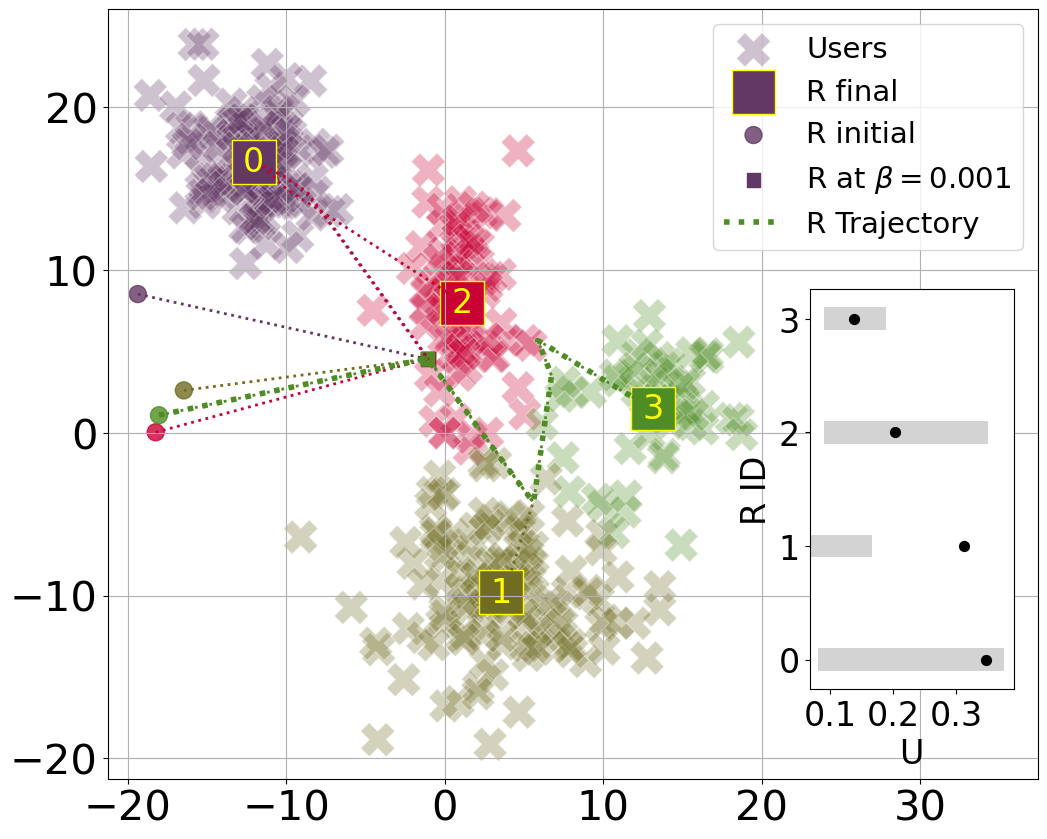

In [101]:
reload(class_flp)
final_cap = cap_array_dac[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_dac[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
class_flp.plot_flp_with_capacity_1(
    flp, demand_means, Y_arr_dac, P_arr_dac,
    x=np.arange(flp.M), data=cap_array_dac[-1],
    min_vals=flp.B, max_vals=flp.C,
    x_expand_factor=0.4, y_expand_factor=0.0,
    figSize=(12, 10), fontSize=30,
    inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True
)

In [102]:
# savedata_dac = {'F_arr':F_arr_dac, 
#             'b_arr':b_arr_dac, 
#             'P_arr':P_arr_dac, 
#             'Y_arr':Y_arr_dac, 
#             't_compute_arr':t_compute_arr_dac, 
#             'cap_array':cap_array_dac,
#             'time_sec':t1_dac-t0_dac,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# dac_data_file = dir + 'AmberPenalty_N400M4_seed349.pkl'

# with open(dac_data_file, 'wb') as file:
#     pickle.dump(savedata_dac, file)

### Our Proposed CBF-based Approach (Constrained)

This approach is introduced in our recent work, *"A Control Barrier Function Approach to Constrained Resource Allocation Problems in a Maximum Entropy Principle Framework,"* arXiv preprint, 2025 ([link](https://arxiv.org/abs/2504.01378)). The key idea is to design a control system over the decision variable such that its trajectory is guaranteed to converge to a KKT point of the original constrained optimization problem, while satisfying the constraints throughout the evolution.


In [105]:
t0_cbf = time.time()
F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_array_cbf = flp.anneal_CBF_CLF(
    x0, beta0, betaf, beta_grow, p1, p2, gamma, 
    alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
    Ftol, xtol, allowPrint=True, printOptimizeIters=False)
t1_cbf = time.time()

beta:2.000e-03	F:2.591e+02
beta:4.000e-03	F:2.384e+02
beta:8.000e-03	F:2.108e+02
beta:1.600e-02	F:1.537e+02
beta:3.200e-02	F:1.146e+02
beta:6.400e-02	F:7.317e+01
beta:1.280e-01	F:5.018e+01
beta:2.560e-01	F:3.986e+01
beta:5.120e-01	F:3.462e+01
beta:1.024e+00	F:3.192e+01
beta:2.048e+00	F:3.051e+01
beta:4.096e+00	F:2.983e+01
beta:8.192e+00	F:2.958e+01
beta:1.638e+01	F:2.932e+01
beta:3.277e+01	F:2.932e+01
beta:6.554e+01	F:2.919e+01
beta:1.311e+02	F:2.920e+01


resource locations:
[[  4.56343874   6.2512968 ]
 [  9.51060749  -6.93557763]
 [-11.94017784  16.66665922]
 [  1.24130812 -10.28950453]]
final capacity: [0.2959479  0.16599336 0.34996108 0.18809767]
upper capacity: [0.37566646 0.16594861 0.35034683 0.1880381 ]
lower capacity: [0.08103281 0.06742873 0.09044801 0.09059003]
Relative capacity constraint violation: -0.000060	0.097508


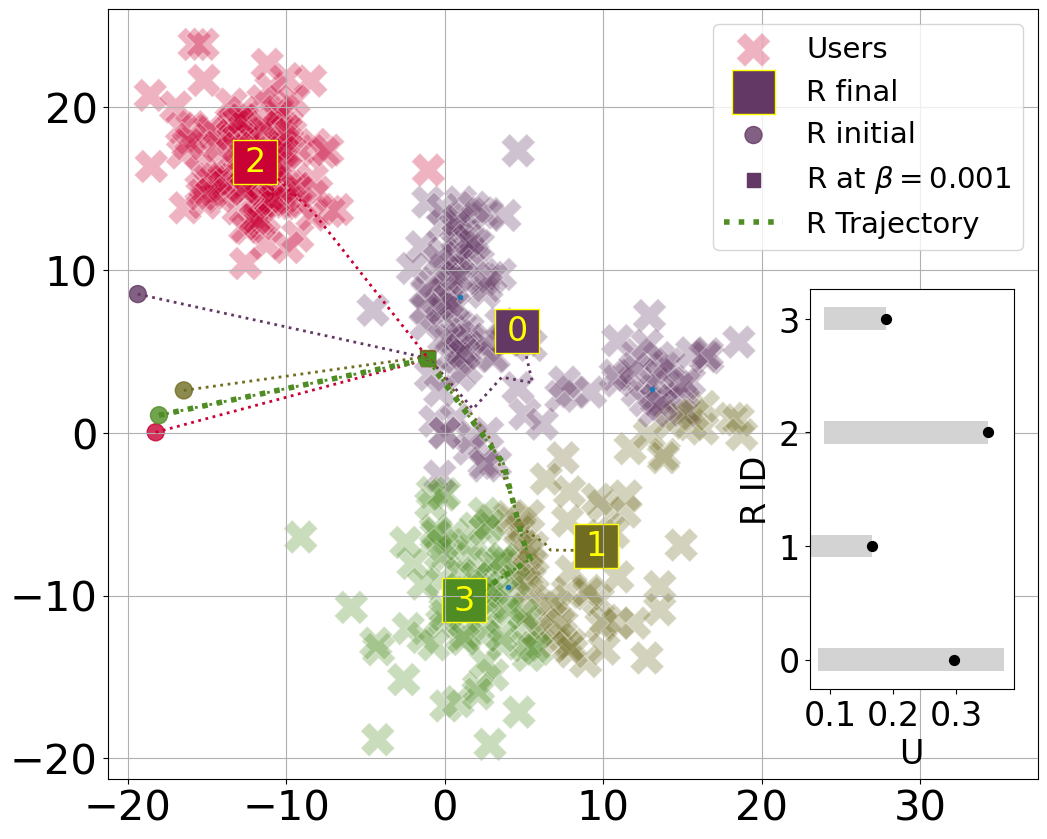

In [112]:
reload(class_flp)
final_cap = cap_array_cbf[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_cbf[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
class_flp.plot_flp_with_capacity_1(
    flp, demand_means, Y_arr_cbf, P_arr_cbf,
    x=np.arange(flp.M), data=cap_array_cbf[-1],
    min_vals=flp.B, max_vals=flp.C,
    x_expand_factor=0.4, y_expand_factor=0.0,
    figSize=(12, 10), fontSize=30,
    inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True
)

In [ ]:
# savedata_cbf = {'F_arr':F_arr_cbf, 
#             'b_arr':b_arr_cbf, 
#             'P_arr':P_arr_cbf, 
#             'Y_arr':Y_arr_cbf, 
#             't_compute_arr':t_compute_arr_cbf, 
#             'cap_array':cap_array_cbf,
#             'time_mins':t1_cbf-t0_cbf,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# cbf_data_file = dir + 'Our_approach_N2000M10_seed830.pkl'

# with open(cbf_data_file, 'wb') as file:
#     pickle.dump(savedata_cbf, file)

### Control Design (Safe Gradient Flow)

This method follows the Control-Barrier-Function-Based Gradient Flow framework proposed by Allibhoy and Cortés in *"Control-Barrier-Function-Based Design of Gradient Flows for Constrained Nonlinear Programming,"* IEEE Transactions on Automatic Control, 2022 ([link](https://doi.org/10.1109/TAC.2022.3200517)). It designs a continuous-time controller to steer the decision variable toward KKT points while enforcing inequality constraints using control barrier functions. While conceptually similar to our approach, SGF can be significantly slower in problems with many constraints or in high-dimensional spaces due to the computational overhead of solving large QPs at each step.


In [108]:
t0_sgf = time.time()
F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_array_sgf = flp.anneal_SGF(x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
t1_sgf = time.time()

beta:2.000e-03	F:2.592e+02
beta:4.000e-03	F:2.371e+02
beta:8.000e-03	F:2.262e+02
beta:1.600e-02	F:1.615e+02
beta:3.200e-02	F:1.030e+02
beta:6.400e-02	F:6.934e+01
beta:1.280e-01	F:5.159e+01
beta:2.560e-01	F:4.278e+01
beta:5.120e-01	F:3.842e+01
beta:1.024e+00	F:3.624e+01
beta:2.048e+00	F:3.515e+01
beta:4.096e+00	F:3.460e+01
beta:8.192e+00	F:3.432e+01
beta:1.638e+01	F:3.418e+01
beta:3.277e+01	F:3.411e+01
beta:6.554e+01	F:3.407e+01
beta:1.311e+02	F:3.405e+01


resource locations:
[[  4.56343874   6.2512968 ]
 [  9.51060749  -6.93557763]
 [-11.94017784  16.66665922]
 [  1.24130812 -10.28950453]]
final capacity: [0.2959479  0.16599336 0.34996108 0.18809767]
upper capacity: [0.37566646 0.16594861 0.35034683 0.1880381 ]
lower capacity: [0.08103281 0.06742873 0.09044801 0.09059003]
Relative capacity constraint violation: -0.000060	0.097508


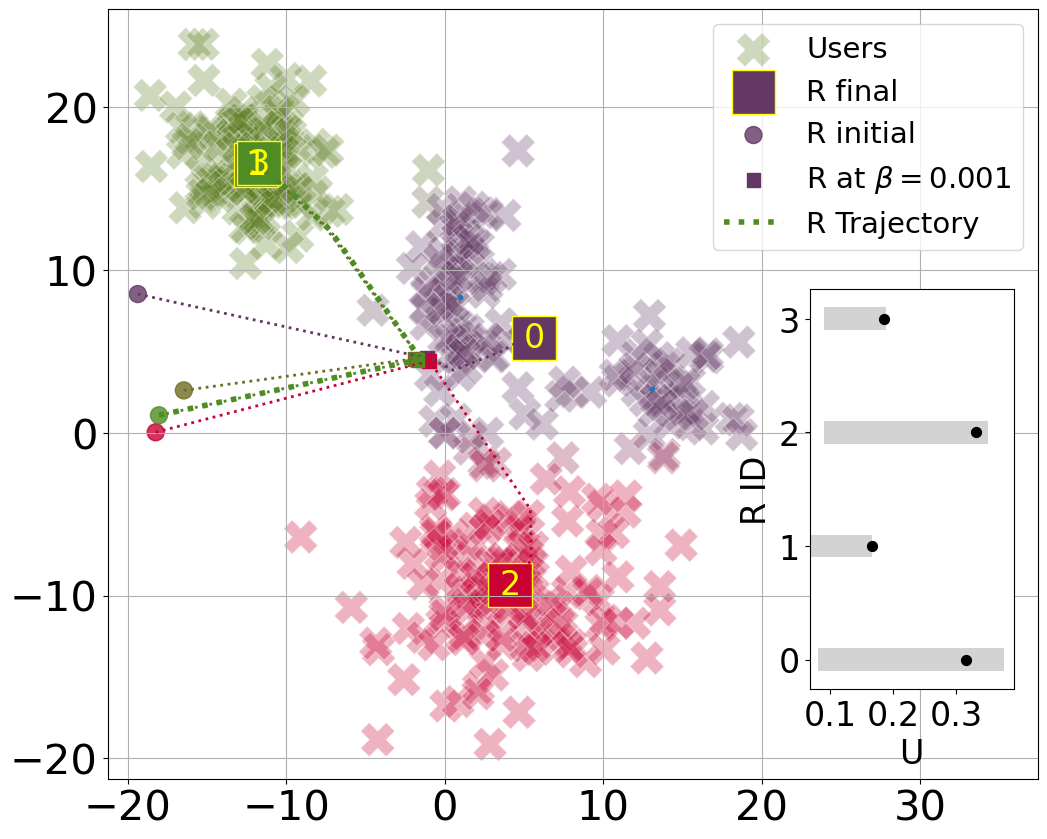

In [115]:
reload(class_flp)
final_cap = cap_array_cbf[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_cbf[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
class_flp.plot_flp_with_capacity_1(
    flp, demand_means, Y_arr_sgf, P_arr_sgf,
    x=np.arange(flp.M), data=cap_array_sgf[-1],
    min_vals=flp.B, max_vals=flp.C,
    x_expand_factor=0.4, y_expand_factor=0.0,
    figSize=(12, 10), fontSize=30,
    inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True
)

In [ ]:
# savedata_sgf = {'F_arr':F_arr_sgf,
#             'b_arr':b_arr_sgf,
#             'P_arr':P_arr_sgf,
#             'Y_arr':Y_arr_sgf,
#             't_compute_arr':t_compute_arr_sgf,
#             'cap_array':cap_array_sgf,
#             'time_mins':t1_sgf-t0_sgf,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# sgf_data_file = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SGF_N400M4_seed349.pkl'

# with open(sgf_data_file, 'wb') as file:
#     pickle.dump(savedata_sgf, file)

### SciPy.optimize SLSQP (Constrained)

This is a standard constrained optimization method implemented in `scipy.optimize.minimize` using the Sequential Least Squares Programming (SLSQP) algorithm. It handles general nonlinear constraints and is widely used due to its simplicity and built-in support in Python. However, it requires gradient and Hessian information, and in practice, it is often the slowest among all compared methods—especially for large-scale problems or when the number of constraints is high.

In [116]:
t0_slsqp = time.time()
F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_array_slsqp = flp.anneal_SLSQP(x0, beta0, betaf, beta_grow, Ftol)
t1_slsqp = time.time()

beta:2.000e-03	F:2.592e+02
beta:4.000e-03	F:2.372e+02
beta:8.000e-03	F:2.262e+02
beta:1.600e-02	F:2.207e+02
beta:3.200e-02	F:1.189e+02
beta:6.400e-02	F:9.397e+01
beta:1.280e-01	F:8.323e+01
beta:2.560e-01	F:4.283e+01
beta:5.120e-01	F:3.793e+01
beta:1.024e+00	F:3.489e+01
beta:2.048e+00	F:3.358e+01
beta:4.096e+00	F:3.282e+01
beta:8.192e+00	F:3.249e+01
beta:1.638e+01	F:3.233e+01
beta:3.277e+01	F:3.225e+01
beta:6.554e+01	F:3.221e+01
beta:1.311e+02	F:3.219e+01


resource locations:
[[  4.56343874   6.2512968 ]
 [  9.51060749  -6.93557763]
 [-11.94017784  16.66665922]
 [  1.24130812 -10.28950453]]
final capacity: [0.2959479  0.16599336 0.34996108 0.18809767]
upper capacity: [0.37566646 0.16594861 0.35034683 0.1880381 ]
lower capacity: [0.08103281 0.06742873 0.09044801 0.09059003]
Relative capacity constraint violation: -0.000060	0.097508


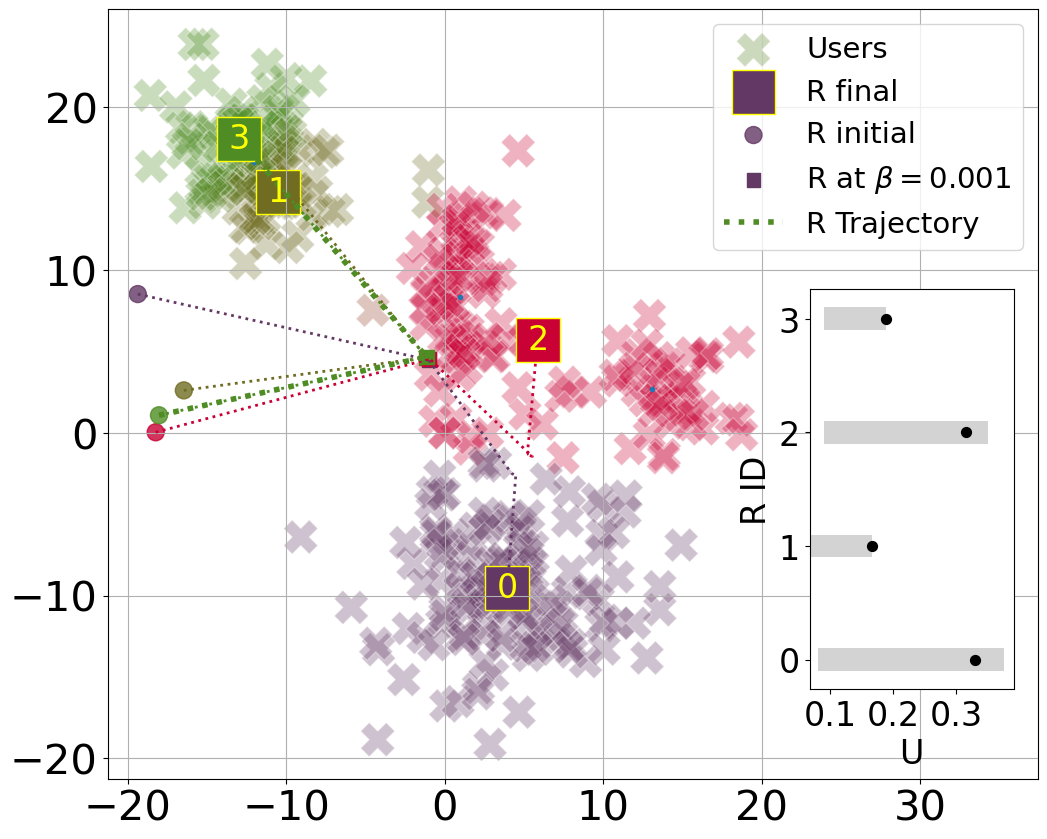

In [119]:
reload(class_flp)
final_cap = cap_array_cbf[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_cbf[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
class_flp.plot_flp_with_capacity_1(
    flp, demand_means, Y_arr_slsqp, P_arr_slsqp,
    x=np.arange(flp.M), data=cap_array_slsqp[-1],
    min_vals=flp.B, max_vals=flp.C,
    x_expand_factor=0.4, y_expand_factor=0.0,
    figSize=(12, 10), fontSize=30,
    inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True
)

In [120]:
# savedata_slsqp = {'F_arr':F_arr_slsqp,
#             'b_arr':b_arr_slsqp,
#             'P_arr':P_arr_slsqp,
#             'Y_arr':Y_arr_slsqp,
#             't_compute_arr':t_compute_arr_slsqp,
#             'cap_array':cap_array_slsqp,
#             'time_mins':t1_slsqp-t0_slsqp,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# slsqp_data_file = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SLSQP_N400M4_seed349.pkl'

# with open(slsqp_data_file, 'wb') as file:
#     pickle.dump(savedata_slsqp, file)

## Results Comparison

In [131]:
# Define constraint violation tolerance
violation_tol = 1e-4

# Baseline timing (CBF)
cbf_time = np.sum(t_compute_arr_cbf)

print("\n=== Resource Allocation: Method Performance Summary ===")
print(f"{'Method':<14} | {'Time (s)':>10} | {'x CBF Time':>11} | {'Final Cost':>12} | {'Min(C-cap)':>12} | {'Min(cap-L)':>12} | {'Feasible?':>9}")
print("-" * 95)

# ---- CBF ----
final_cap = cap_array_cbf[-1]
viol_c = np.min(flp.C - final_cap)
viol_b = np.min(final_cap - flp.B)
feasible = "✅" if viol_c >= -violation_tol and viol_b >= -violation_tol else "❌"
print(f"{'CBF':<14} | {cbf_time:>10.6f} | {1.0:>11.6f} | {F_arr_cbf[-1]:>12.6f} | {viol_c:>12.6f} | {viol_b:>12.6f} | {feasible:>9}")

# ---- SGF ----
total_time = np.sum(t_compute_arr_sgf)
final_cap = cap_array_sgf[-1]
viol_c = np.min(flp.C - final_cap)
viol_b = np.min(final_cap - flp.B)
feasible = "✅" if viol_c >= -violation_tol and viol_b >= -violation_tol else "❌"
print(f"{'SGF':<14} | {total_time:>10.6f} | {total_time/cbf_time:>11.6f} | {F_arr_sgf[-1]:>12.6f} | {viol_c:>12.6f} | {viol_b:>12.6f} | {feasible:>9}")

# ---- SLSQP ----
total_time = np.sum(t_compute_arr_slsqp)
final_cap = cap_array_slsqp[-1]
viol_c = np.min(flp.C - final_cap)
viol_b = np.min(final_cap - flp.B)
feasible = "✅" if viol_c >= -violation_tol and viol_b >= -violation_tol else "❌"
print(f"{'SLSQP':<14} | {total_time:>10.6f} | {total_time/cbf_time:>11.6f} | {F_arr_slsqp[-1]:>12.6f} | {viol_c:>12.6f} | {viol_b:>12.6f} | {feasible:>9}")

# ---- DA (penalty) ----
total_time = np.sum(t_compute_arr_dac)
final_cap = cap_array_dac[-1]
viol_c = np.min(flp.C - final_cap)
viol_b = np.min(final_cap - flp.B)
feasible = "✅" if viol_c >= -violation_tol and viol_b >= -violation_tol else "❌"
print(f"{'DA (penalty)':<14} | {total_time:>10.6f} | {total_time/cbf_time:>11.6f} | {F_arr_dac[-1]:>12.6f} | {viol_c:>12.6f} | {viol_b:>12.6f} | {feasible:>9}")



=== Resource Allocation: Method Performance Summary ===
Method         |   Time (s) |  x CBF Time |   Final Cost |   Min(C-cap) |   Min(cap-L) | Feasible?
-----------------------------------------------------------------------------------------------
CBF            |  18.464762 |    1.000000 |    29.196155 |    -0.000060 |     0.097508 |         ✅
SGF            |  72.999631 |    3.953456 |    34.045735 |     0.000013 |     0.095308 |         ✅
SLSQP          | 906.744993 |   49.106779 |    32.191521 |    -0.000000 |     0.097448 |         ✅
DA (penalty)   |  31.694463 |    1.716484 |    19.556701 |    -0.146551 |     0.046910 |         ❌


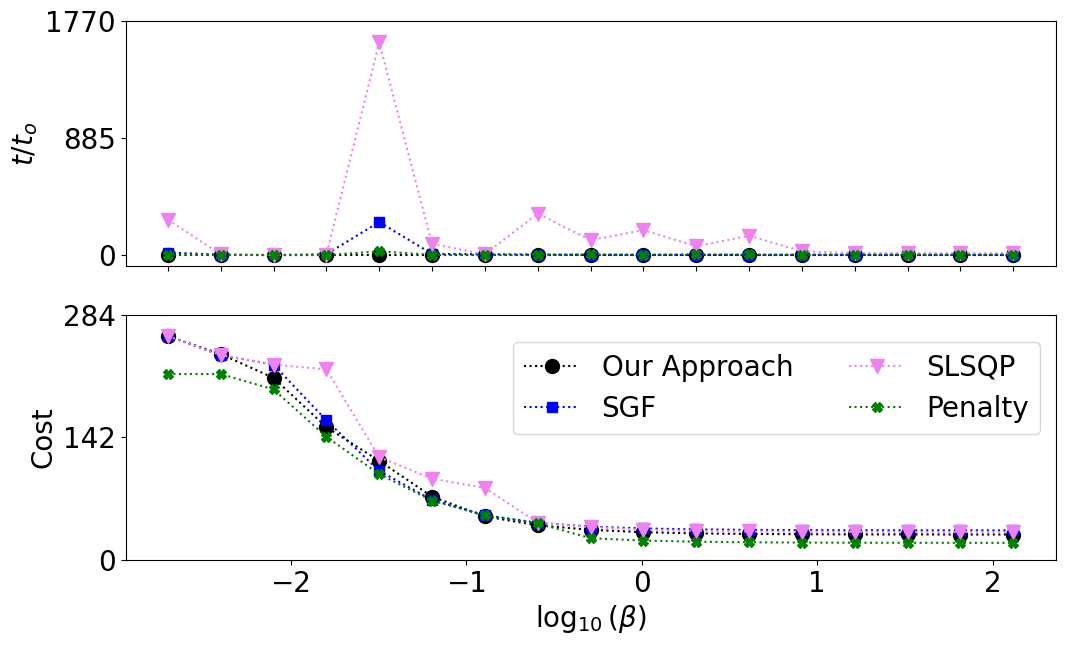

In [132]:
# print(f'SLSQP total time:\t{np.sum(t_compute_arr_slsqp):.6f} sec\t{np.sum(t_compute_arr_slsqp)/np.sum(t_compute_arr_cbf):.6f} times')
t_rel_arr_cbf = np.array(t_compute_arr_cbf)/np.array(t_compute_arr_cbf)
t_rel_arr_sgf = np.array(t_compute_arr_sgf)/np.array(t_compute_arr_cbf)
t_rel_arr_slsqp = np.array(t_compute_arr_slsqp)/np.array(t_compute_arr_cbf)
t_rel_arr_dac = np.array(t_compute_arr_dac)/np.array(t_compute_arr_cbf)
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(np.log(b_arr_cbf)/np.log(10), t_rel_arr_cbf, marker='o', markersize=10, linestyle='dotted', color = 'black', label = 'Our')
plt.plot(np.log(b_arr_sgf)/np.log(10), t_rel_arr_sgf, marker='s', markersize=7, linestyle='dotted', color = 'blue', label = 'SGF')
plt.plot(np.log(b_arr_slsqp)/np.log(10), t_rel_arr_slsqp, marker='v', markersize=10, linestyle='dotted', color = 'violet', label = 'SLSQP')
plt.plot(np.log(b_arr_dac)/np.log(10), t_rel_arr_dac, marker='X', markersize=7, linestyle='dotted', color = 'green', label = 'Penalty')
# plt.xlabel(rf'$\log_{{10}}(\beta)$')
plt.ylabel(rf'${{t}}/{{t_o}}$', fontsize=20)
ymin_t, ymax_t = plt.ylim()
yticks = [int(y) for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
plt.xticks(np.log(b_arr_cbf)/np.log(10), [f" " for b in b_arr_cbf], rotation=0)  # Set x-axis labels as (N, M)
plt.yticks(yticks, fontsize=20)
# plt.title(rf'Free energy minimization time at increasing beta values for (N,M) = {flp.N, flp.M}')
# plt.grid()
# plt.legend(fontsize=17, ncol=4, loc="center", bbox_to_anchor=(0.8, -0.2))
# plt.show()
plt.subplot(2,1,2)
plt.plot(np.log(b_arr_cbf)/np.log(10), F_arr_cbf, marker='o', markersize=10, linestyle='dotted', color = 'black', label = 'Our Approach')
plt.plot(np.log(b_arr_sgf)/np.log(10), F_arr_sgf, marker='s', markersize=7, linestyle='dotted', color = 'blue', label = 'SGF')
plt.plot(np.log(b_arr_slsqp)/np.log(10), F_arr_slsqp, marker='v', markersize=10, linestyle='dotted', color = 'violet', label = 'SLSQP')
plt.plot(np.log(b_arr_dac)/np.log(10), F_arr_dac, marker='X', markersize=7, linestyle='dotted', color = 'green', label = 'Penalty')
plt.xlabel(rf'$\log_{{10}}(\beta)$', fontsize = 20)
plt.ylabel(rf'Cost', fontsize=20)
ymin_c, ymax_c = plt.ylim()
yticks = [int(y) for y in np.linspace(0.0, ymax_c*(1+0.05), 3)]
plt.yticks(yticks, fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks(np.log(b_arr_cbf)/np.log(10), rotation=0)  # Set x-axis labels as (N, M)
# plt.title(rf'Optimal free energy at increasing beta values for (N,M) = {flp.N, flp.M}')
# plt.grid()
plt.legend(fontsize=20, ncol=2, loc="center", bbox_to_anchor=(0.7, 0.7))
# plt.savefig(dir+'time_cost_SGF_Our.pdf', format="pdf")
plt.show()